
Discrepancy found in graph 7-1
           V5            
   DAG_to_PAG fastdag2pag
V7       -1.0         2.0


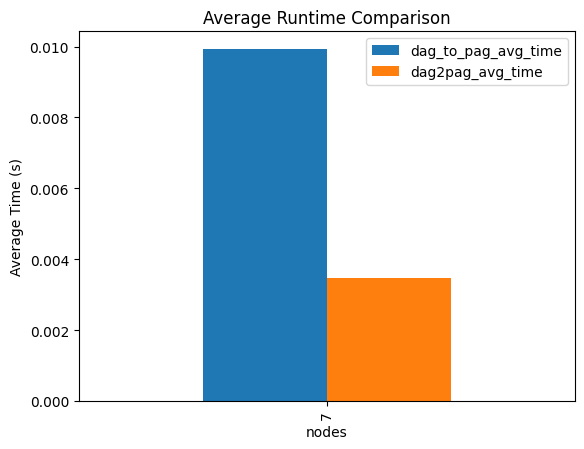

In [5]:
# Compare DAG_to_PAG and fastdag2pag Performance and Output
# This notebook compares the speed and output consistency of DAG_to_PAG (from DAG_to_PAG.py) and dag2pag (from fastdag2pag) for 5, 6, 7, 8, and 9 nodes, each with 5 random DAGs.
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
from DAGtoPAGPython.DAG_to_PAG import DAG_to_PAG
from fastdag2pag.dag2pag import dag2pag
from fastdag2pag.Random_Graph import ErdosRenyi
import matplotlib.pyplot as plt

node_sizes = [7]  
num_trials = 1
results = []

for n_nodes in node_sizes:
    dag2pag_times = []
    dag_to_pag_times = []
    match_count = 0
    for trial in range(num_trials):
        # print(f'Node size: {n_nodes}, Trial: {trial+1}/{num_trials}')
        # Generate random DAG adjacency matrix
        ER_graph_gen = ErdosRenyi(n_nodes, expected_degree=2, def_dataframe=True, seed=321)
        graph = ER_graph_gen.get_random_graph()
        num_latent = int(n_nodes * 0.1) if n_nodes >= 10 else 1
        adj = ER_graph_gen.set_latent_nodes(graph, num_latent=num_latent, selection_bias=False)
        latent_nodes = [node for node in adj.columns if node.startswith('L')]  
        if trial == 0:
            dag1 = adj.copy()
        # DAG_to_PAG  based causal-learn
        t0 = time.time()
        pag1 = DAG_to_PAG(adj, latent_nodes=latent_nodes,verbose=True)
        t1 = time.time()
        dag_to_pag_times.append(t1 - t0)

        # fastdag2pag
        t2 = time.time()
        pag2 = dag2pag(adj, latent_nodes=latent_nodes)['PAG.DataFrame']
        t3 = time.time()
        dag2pag_times.append(t3 - t2)

        # Compare outputs (matrix equality)
        try:
            match = pag1.equals(pag2)
        except Exception:
            match = np.array_equal(np.array(pag1), np.array(pag2))
        if pag1.equals(pag2):
            match_count += 1
        else:
            print(f"Discrepancy found in graph {n_nodes}-{trial+1}")
            diff = pag1.compare(pag2, result_names=("DAG_to_PAG", "fastdag2pag"))
            print(diff)

    results.append({
        'nodes': n_nodes,
        'dag_to_pag_avg_time': np.mean(dag_to_pag_times),
        'dag2pag_avg_time': np.mean(dag2pag_times),
        # 'match_ratio': match_count / num_trials
    })

results_df = pd.DataFrame(results)
# print(results_df)
results_df.plot(x='nodes', y=['dag_to_pag_avg_time', 'dag2pag_avg_time'], kind='bar', title='Average Runtime Comparison')
plt.ylabel('Average Time (s)')
plt.show()
# print('Match ratio (PAG matrix equality) for each node size:')
# print(results_df[['nodes', 'match_ratio']])

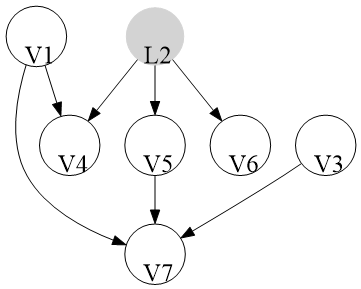

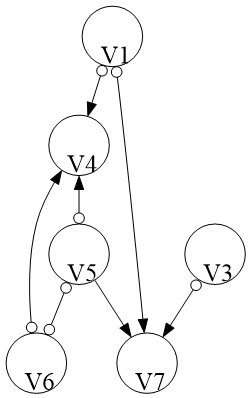

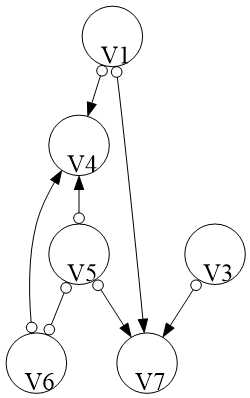

In [6]:
from fastdag2pag.mixgraph import MixGraph
from IPython.display import Image, display
dag = MixGraph()
dag.from_pandas_adjacency(dag1, graph_type='DAG')
dag_pydot = dag.to_pydot()
png_bytes = dag_pydot.create_png()
display(Image(png_bytes))
Pag1 = MixGraph()
Pag1.from_pandas_adjacency(pag1, graph_type='MG')
Pag1_pydot = Pag1.to_pydot()
png_bytes_pag1 = Pag1_pydot.create_png()
display(Image(png_bytes_pag1))
Pag2 = MixGraph()
Pag2.from_pandas_adjacency(pag2, graph_type='MG')
Pag2_pydot = Pag2.to_pydot()
png_bytes_pag2 = Pag2_pydot.create_png()
display(Image(png_bytes_pag2))